In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# List all files in the current directory
dir = '../data.lbm/src_2/output/'
# dir = '../output.lbm/'
# os.listdir(dir)

# Partícula

In [4]:
particleDf = pd.read_csv(dir+"particlesTrj.csv")
particleDf

,tick,time,particleId,position_x,position_y,velocity_x,velocity_y,angularVelocity
0,0,0.0,1,600.0,60.0,0.0,0.0,0.0001
1,100,100.0,1,600.0,60.0,0.0,0.0,0.0001
2,200,200.0,1,600.0,60.0,0.0,0.0,0.0001
3,300,300.0,1,600.0,60.0,0.0,0.0,0.0001
4,400,400.0,1,600.0,60.0,0.0,0.0,0.0001
...,...,...,...,...,...,...,...,...
57,5700,5700.0,1,600.0,60.0,0.0,0.0,0.0001
58,5800,5800.0,1,600.0,60.0,0.0,0.0,0.0001
59,5900,5900.0,1,600.0,60.0,0.0,0.0,0.0001
60,6000,6000.0,1,600.0,60.0,0.0,0.0,0.0001


# Fluido

In [5]:
tick = particleDf.tick.values[-1]
fluidDf = pd.read_csv(dir + f"fluidTrj_{tick}.csv").set_index(["id_x","id_y"]).sort_index()

fluidDf

tick    time  coordinate_x  coordinate_y  massDensity  \
id_x id_y                                                          
1    1     6000  6000.0             1             1          0.0   
     2     6000  6000.0             1             2          0.0   
     3     6000  6000.0             1             3          0.0   
     4     6000  6000.0             1             4          0.0   
     5     6000  6000.0             1             5          0.0   
...         ...     ...           ...           ...          ...   
1201 1197  6000  6000.0          1201          1197          0.0   
     1198  6000  6000.0          1201          1198          0.0   
     1199  6000  6000.0          1201          1199          0.0   
     1200  6000  6000.0          1201          1200          0.0   
     1201  6000  6000.0          1201          1201          0.0   

           fluidVelocity_x  fluidVelocity_y   f1   f2   f3   f4   f5   f6  \
id_x id_y                                                                   
1    1                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     2                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     3                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     4                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     5                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                    ...              ...  ...  ...  ...  ...  ...  ...   
1201 1197              0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     1198              0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     1199              0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     1200              0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     1201              0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   

            f7   f8   f9  
id_x id_y                 
1    1     0.0  0.0  0.0  
     2     0.0  0.0  0.0  
     3     0.0  0.0  0.0  
     4     0.0  0.0  0.0  
     5     0.0  0.0  0.0  
...        ...  ...  ...  
1201 1197  0.0  0.0  0.0  
     1198  0.0  0.0  0.0  
     1199  0.0  0.0  0.0  
     1200  0.0  0.0  0.0  
     1201  0.0  0.0  0.0  

[1442401 rows x 16 columns]

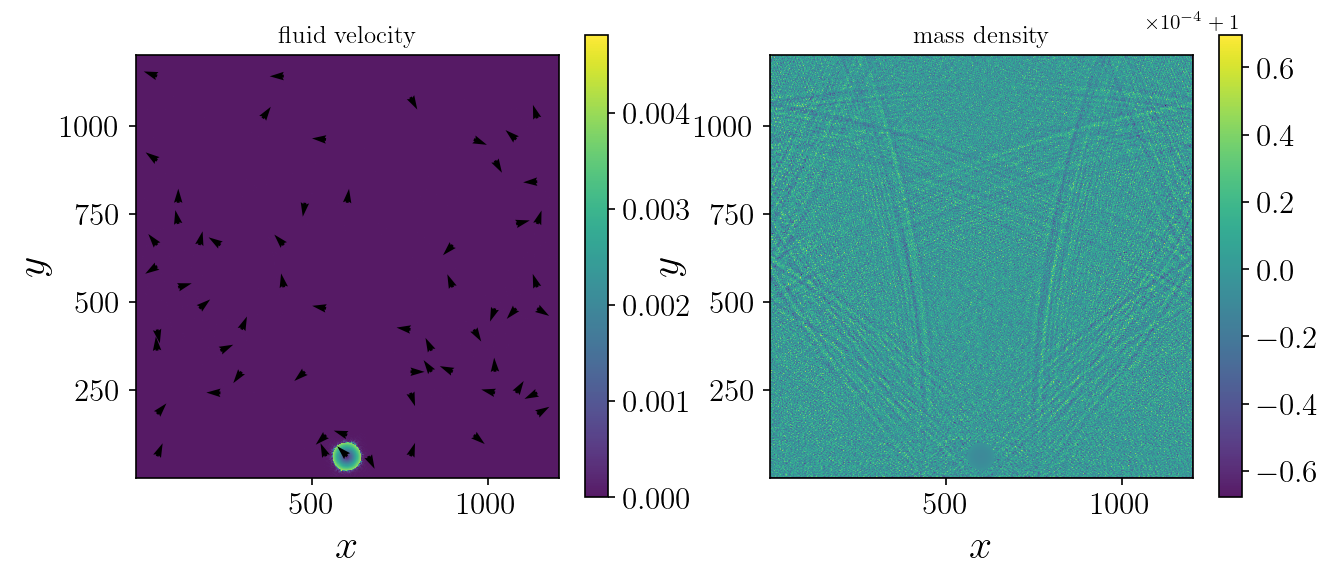

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))

# Create a meshgrid for plotting
x_unique = fluidDf['coordinate_x'].unique()
y_unique = fluidDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

c = axes[0].pcolormesh(X, Y,
    np.sqrt(fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2).unstack().values.transpose(),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[0].set_title('fluid velocity')

maskStep = int(len(x_unique)/20)
# Create a mask for filtering
mask = (fluidDf['coordinate_x'].isin(x_unique[::maskStep])) & (fluidDf['coordinate_y'].isin(y_unique[::maskStep])) & (
    (fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2 > 1e-10)
)
# Filter the DataFrame
filtered_df = fluidDf[mask]

axes[0].quiver(
    filtered_df['coordinate_x'], 
    filtered_df['coordinate_y'], 
    (filtered_df.fluidVelocity_x / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
    (filtered_df.fluidVelocity_y / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
    scale = 30,
)

c = axes[1].pcolormesh(X,Y,
    fluidDf.massDensity.unstack().values.transpose(),
    vmin=min(fluidDf.query("massDensity > 1e-2").massDensity.values),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[1].set_title('mass density')

for i in range(2):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary

plt.show()

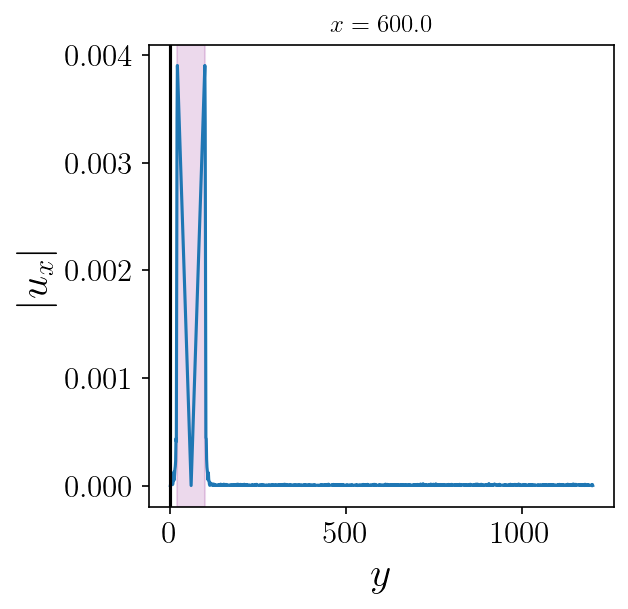

In [12]:
# encuentro el primer id_x tal que coordinate_x sea mayor o igual a la posición de la partícula
position_x = particleDf.query(f'tick == {tick}').position_x.values[0]
id = fluidDf.query(f"coordinate_x >= {position_x}").reset_index().iloc[0].filter(["id_x"]).values[0]

# ploteo v_x(y, x = 0)
v_x = fluidDf.loc[id].filter(["coordinate_y", "fluidVelocity_x"])

wallPosition = 0

plt.plot(v_x.coordinate_y, abs(v_x.fluidVelocity_x)) 
plt.xlabel("$y$")
plt.ylabel("$|u_x|$")
plt.title(f"$x = {fluidDf.query(f"id_x == {id}").iloc[0].filter(["coordinate_x"]).values[0]}$")
plt.axvline(wallPosition, color = "k")
plt.axvspan(60-40, 60+40, color='purple', alpha=0.15)  # Shade the sphere

plt.show()

# Tensor de estrés

In [13]:
stressDf = pd.read_csv(dir + "stressTensor.csv").set_index(["id_x","id_y"]).sort_index()

stressDf

tick    time  coordinate_x  coordinate_y  component_xx  \
id_x id_y                                                           
1    1     6000  6000.0             1             1          -0.0   
     2     6000  6000.0             1             2          -0.0   
     3     6000  6000.0             1             3          -0.0   
     4     6000  6000.0             1             4          -0.0   
     5     6000  6000.0             1             5          -0.0   
...         ...     ...           ...           ...           ...   
1201 1197  6000  6000.0          1201          1197          -0.0   
     1198  6000  6000.0          1201          1198          -0.0   
     1199  6000  6000.0          1201          1199          -0.0   
     1200  6000  6000.0          1201          1200          -0.0   
     1201  6000  6000.0          1201          1201          -0.0   

           component_yx  component_xy  component_yy  
id_x id_y                                            
1    1             -0.0          -0.0          -0.0  
     2             -0.0          -0.0          -0.0  
     3             -0.0          -0.0          -0.0  
     4             -0.0          -0.0          -0.0  
     5             -0.0          -0.0          -0.0  
...                 ...           ...           ...  
1201 1197          -0.0          -0.0          -0.0  
     1198          -0.0          -0.0          -0.0  
     1199          -0.0          -0.0          -0.0  
     1200          -0.0          -0.0          -0.0  
     1201          -0.0          -0.0          -0.0  

[1442401 rows x 8 columns]

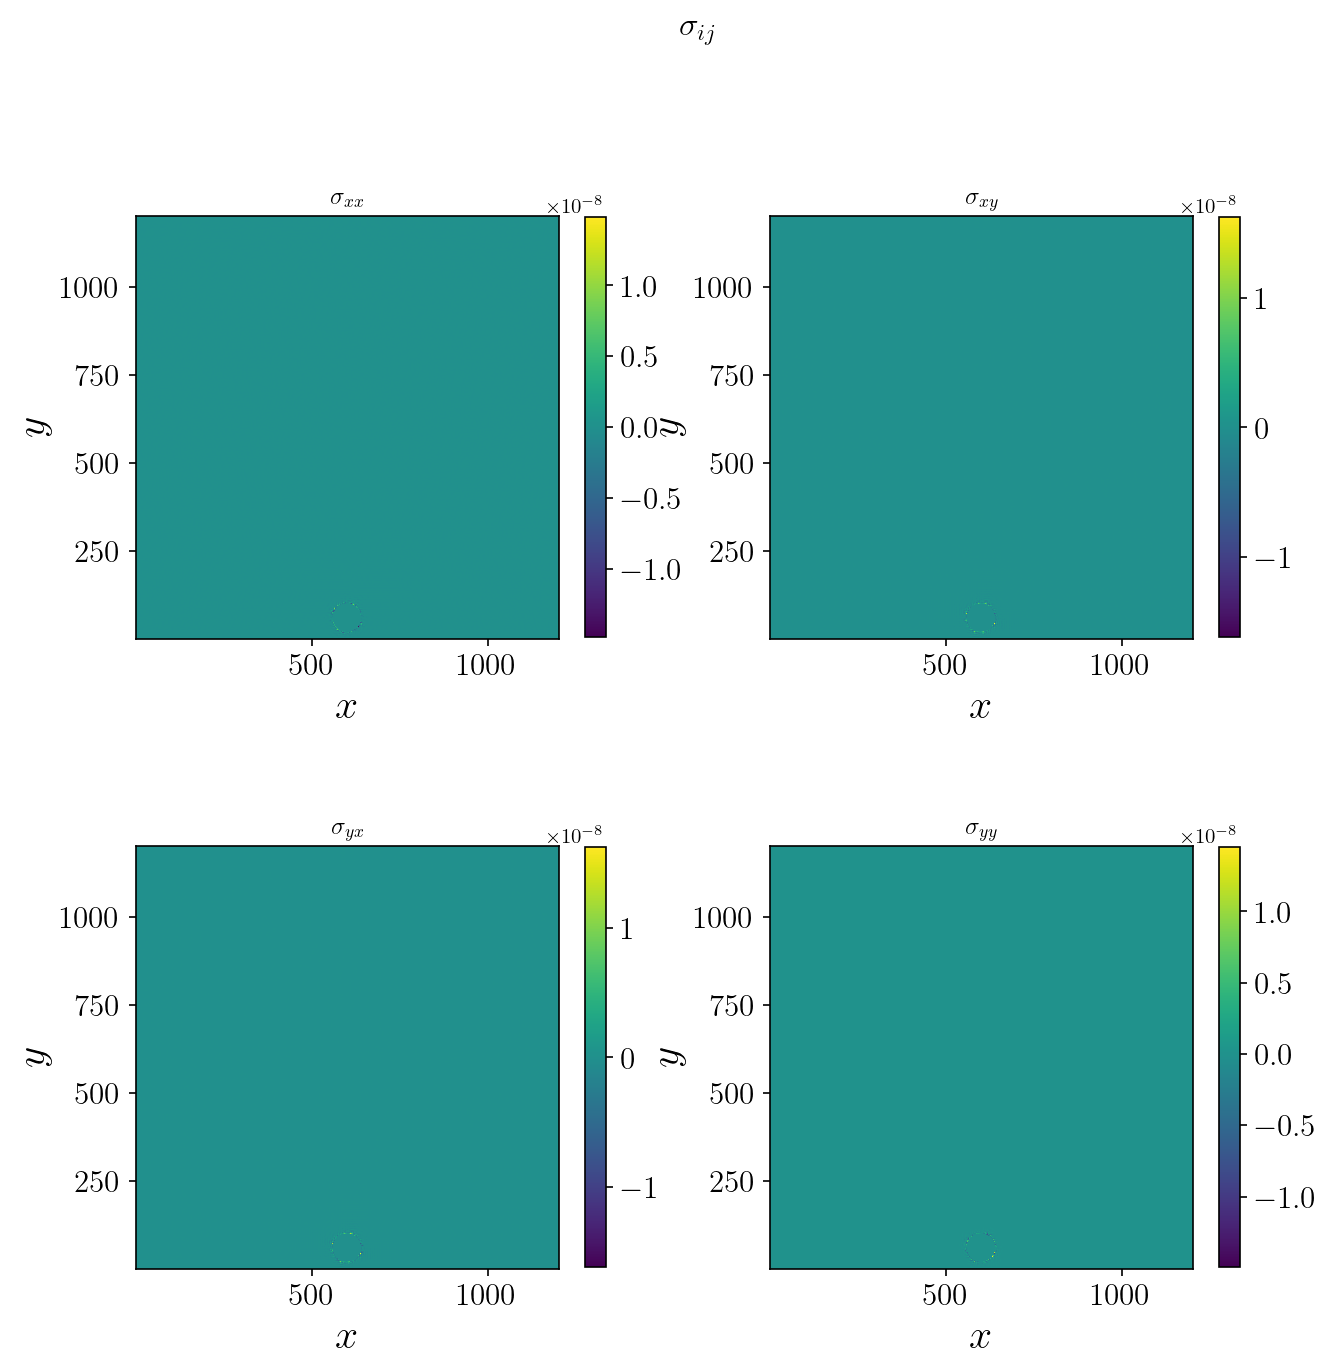

In [14]:
# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = stressDf['coordinate_x'].unique()
y_unique = stressDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

# plotting
c = axes[0,0].pcolormesh(X,Y,stressDf["component_xx"].unstack().values.transpose()); cs.append(c);
axes[0,0].set_title("$\\sigma_{xx}$")

c = axes[0,1].pcolormesh(X,Y,stressDf["component_xy"].unstack().values.transpose()); cs.append(c);
axes[0,1].set_title("$\\sigma_{xy}$")

c = axes[1,0].pcolormesh(X,Y,stressDf["component_yx"].unstack().values.transpose()); cs.append(c);
axes[1,0].set_title("$\\sigma_{yx}$")

c = axes[1,1].pcolormesh(X,Y,stressDf["component_yy"].unstack().values.transpose()); cs.append(c);
axes[1,1].set_title("$\\sigma_{yy}$")


# for ax in axes.flat:
for i in range(4):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")    
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary
#     ax.axhline(wallPosition, color = "k", alpha = 0.1)
#     ax.axhspan(-2, wallPosition, color='gray', alpha=0.1)  # Shade the wall

plt.show()

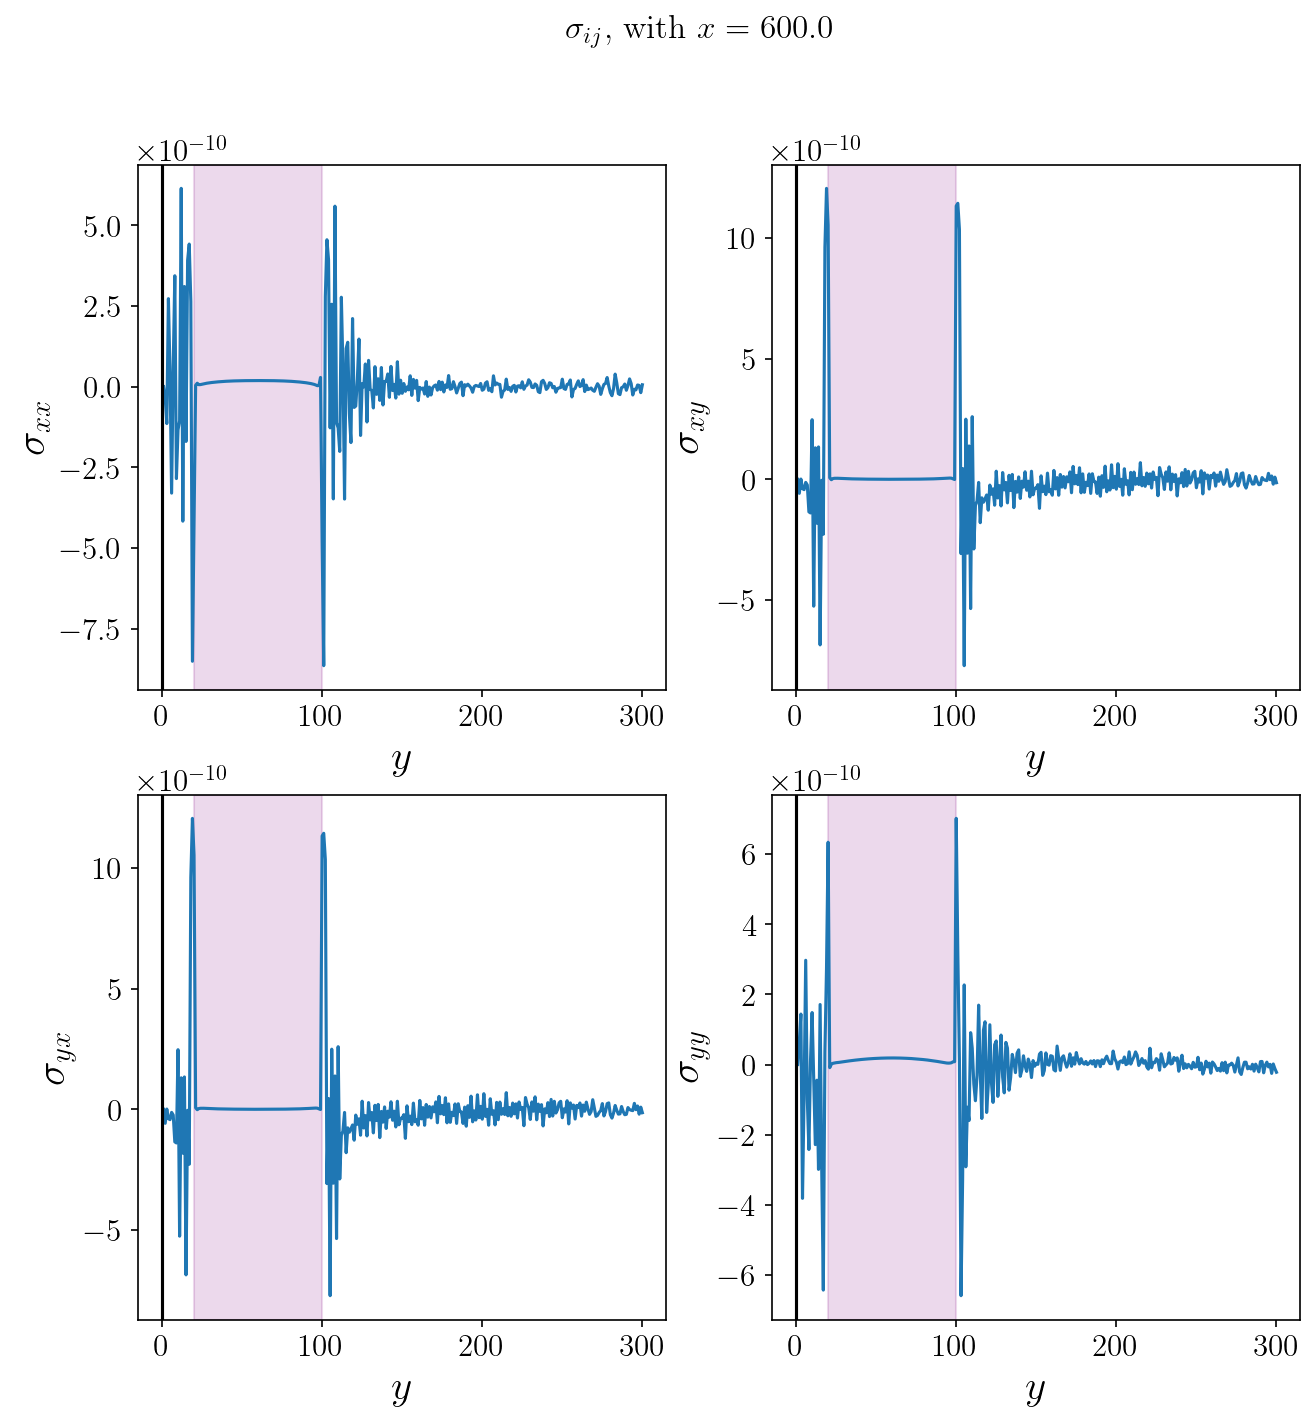

In [15]:
# encuentro el primer id_x tal que coordinate_x sea mayor o igual a cero
id = stressDf.query("coordinate_x >= 600").reset_index().iloc[0].filter(["id_x"]).values[0]

# ploteo v_x(y, x = 0)
sigma_x = stressDf.loc[id].filter(["coordinate_y", "component_xx", "component_xy", "component_yx", "component_yy"])


# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$, with " f"$x = {stressDf.query(f"id_x == {id}").iloc[0].filter(["coordinate_x"]).values[0]}$", fontsize=16)

axes[0,0].plot(sigma_x.query("coordinate_y <= 300").coordinate_y, sigma_x.query("coordinate_y <= 300").component_xx) 
axes[0,0].set_ylabel("$\\sigma_{xx}$")    
axes[0,1].plot(sigma_x.query("coordinate_y <= 300").coordinate_y, sigma_x.query("coordinate_y <= 300").component_xy) 
axes[0,1].set_ylabel("$\\sigma_{xy}$")    
axes[1,0].plot(sigma_x.query("coordinate_y <= 300").coordinate_y, sigma_x.query("coordinate_y <= 300").component_yx) 
axes[1,0].set_ylabel("$\\sigma_{yx}$")    
axes[1,1].plot(sigma_x.query("coordinate_y <= 300").coordinate_y, sigma_x.query("coordinate_y <= 300").component_yy) 
axes[1,1].set_ylabel("$\\sigma_{yy}$")    

for ax in axes.flatten():
    ax.set_xlabel("$y$")
    ax.yaxis.set_major_formatter(formatter)
    ax.axvline(wallPosition, color = "k")
    ax.axvspan(20, 100, color='purple', alpha=0.15)  # Shade the sphere

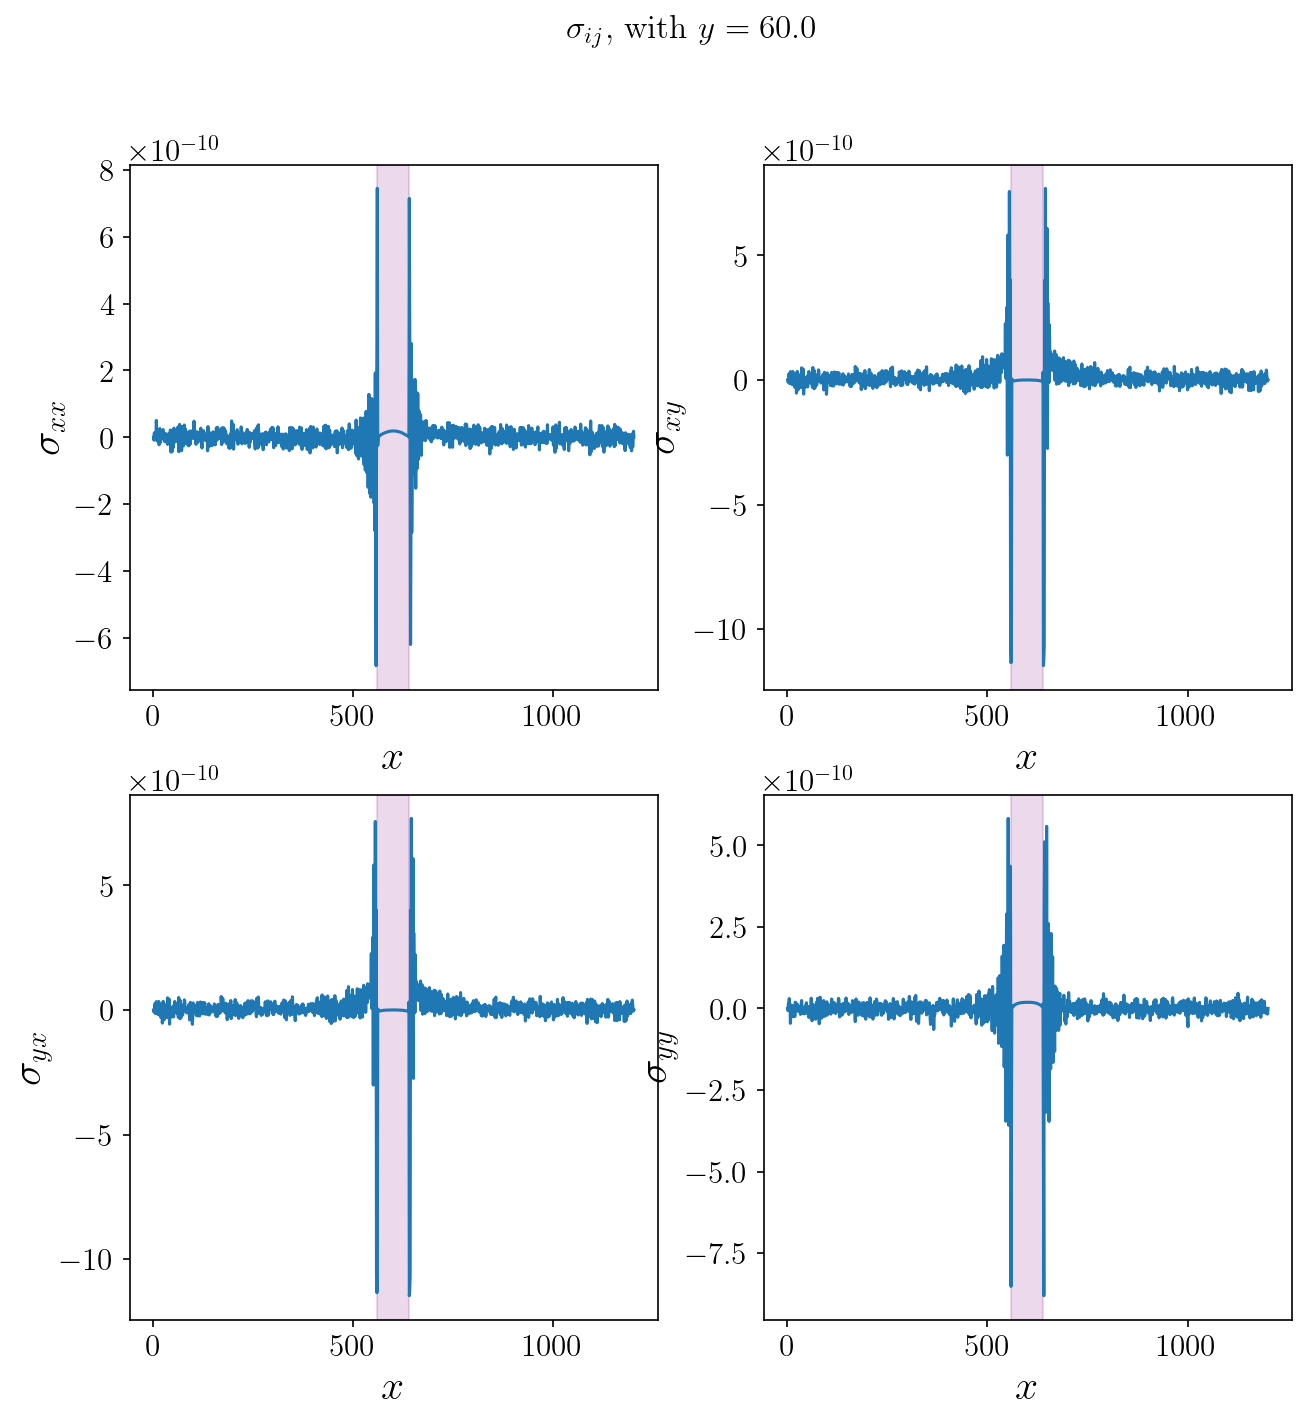

In [11]:
# encuentro el primer id_x tal que coordinate_x sea mayor o igual a cero
id = stressDf.query("coordinate_y >= 60").reset_index().iloc[0].filter(["id_y"]).values[0]

sigma_y = stressDf.query(f"id_y == {id}").filter(["coordinate_x", "component_xx", "component_xy", "component_yx", "component_yy"])


# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$, with " f"$y = {stressDf.query(f"id_y == {id}").iloc[0].filter(["coordinate_y"]).values[0]}$", fontsize=16)

axes[0,0].plot(sigma_y.coordinate_x, sigma_y.component_xx) 
axes[0,0].set_ylabel("$\\sigma_{xx}$")    
axes[0,1].plot(sigma_y.coordinate_x, sigma_y.component_xy) 
axes[0,1].set_ylabel("$\\sigma_{xy}$")    
axes[1,0].plot(sigma_y.coordinate_x, sigma_y.component_yx) 
axes[1,0].set_ylabel("$\\sigma_{yx}$")    
axes[1,1].plot(sigma_y.coordinate_x, sigma_y.component_yy) 
axes[1,1].set_ylabel("$\\sigma_{yy}$")    

for ax in axes.flatten():
    ax.set_xlabel("$x$")
    ax.yaxis.set_major_formatter(formatter)
    ax.axvspan(560, 640, color='purple', alpha=0.15)  # Shade the sphere